In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
from IPython.core.display import display, HTML

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('spectrograms_segmented.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 693


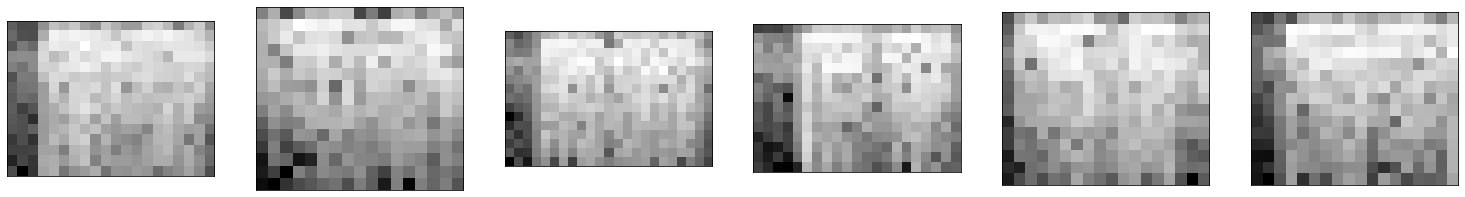

In [4]:
n=6
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(specgrams[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [5]:
rows = specgrams[0].shape[0]
print(rows)

# def encode(specgrams, min_columns, max_columns):
#     reshape = []
#     for specgram in specgrams:
#         if min_columns <= specgram.shape[1] <= max_columns:
#             reshape.append(specgram[:,:min_columns].reshape(rows*min_columns))

#     return reshape

# def decode(encoded_specgrams):
#     reconstruct = []
#     columns = encoded_specgrams[i].shape[0]
#     for specgram in encoded_specgrams:
#         reconstruct.append(specgram[i].reshape(rows, int(columns/rows)))
    
#     return reconstruct

################################################

def encode(specgrams, min_columns, max_columns):
    return [specgram[:,:min_columns].reshape(rows*min_columns) for specgram in specgrams if min_columns <= specgram.shape[1] <= max_columns]

def decode(encoded_specgrams):
    columns = encoded_specgrams[i].shape[0]
    return [specgram.reshape(rows, int(columns/rows)) for specgram in encoded_specgrams]

15


In [6]:
reshape = encode(specgrams, 18, 22)
reconstruct = decode(reshape)

X_train, X_test = train_test_split(reshape, test_size=0.25, shuffle=False)
print(X_train[10].shape)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

(270,)
Training samples: 217
Test samples: 73


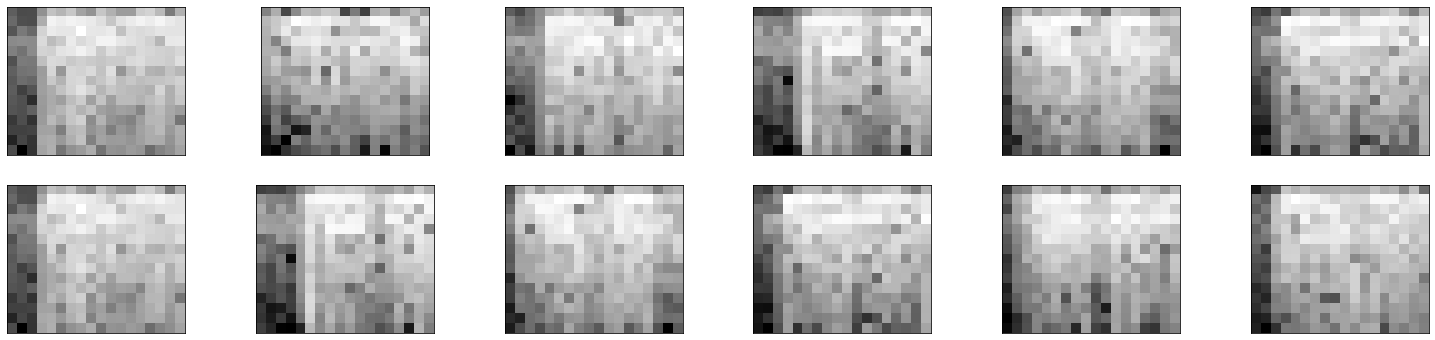

In [7]:
# Testing encode and decode: upper(original) must be equal to lower(encoded and decoded)

n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(specgrams[i][:,:18], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(reconstruct[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Autoencoder Model

In [18]:
input_img = Input(X_train[0].shape)

# encoder
code = Dense(102, activation='relu')(input_img)
code = Dense(34, activation='relu')(code)

# decoder
x_hat = Dense(102, activation='relu')(code)
x_hat = Dense(306, activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 270)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 102)               27642     
_________________________________________________________________
dense_34 (Dense)             (None, 34)                3502      
_________________________________________________________________
dense_35 (Dense)             (None, 102)               3570      
_________________________________________________________________
dense_36 (Dense)             (None, 306)               31518     
Total params: 66,232
Trainable params: 66,232
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')

# tamanho do batch por iteracao
batch_size = 1

# número de épocas 
epochs = 10

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit([X_train], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=([X_test], [X_test]))

ValueError: Error when checking target: expected dense_4 to have shape (306,) but got array with shape (270,)

In [ ]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
decoded_test = decode(X_test)
decoded_predictions = decode(autoencoder.predict([X_test]))

n=5
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(decoded_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_predictions[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()